In [1]:
# HIDE CODE
from dateutil.relativedelta import relativedelta
from joblib import dump, load
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 12})


import warnings
import sys
import os
sys.path.append('/home/server/gli-data-science/')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import os
import ds_db
import helper_db
from helper import transform_to_rupiah, rupiah_format

import pickle
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display, HTML, display_html, IFrame
import ipywidgets as ipyw

def side_by_side_display(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    styles = [
        dict(selector="caption", props=[("caption-side", "center"), ("font-size", "100%"), ("color", )])]
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline; font-size:85%' ").set_precision(2).set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0"

    display(HTML(output))

    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso, RANSACRegressor, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, export_text, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR, SVC, LinearSVC
import xgboost as xgb 


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split


import textwrap
def split_label(list_label):
    list_label = list(list_label)
    list_label = ["<br>".join(textwrap.wrap(t, width=12)) for t in list_label ]
    return list_label

### ide kasar
> 
* daily job to loop all member alfagift 10 juta
* compute feature trx voucher used, # of trx, # of sales
* compute feature event app site open / view product / atc
* updating each feature and re predict churn feature
* lets play in month - 3 for each define trx and event feature

In [2]:
df_pv_ = pd.read_csv('./pv_31Dec21.csv')
df_pv_['EVENT_TIME'] = pd.to_datetime(df_pv_['EVENT_TIME']).dt.strftime('%Y-%m')

df_pv = df_pv_.groupby(['TRO_MEMBERS','EVENT_TIME']).agg(PV=('COUNT_VIEW_PRODUCT','sum'))\
        .unstack(level=1).fillna(0).reset_index()

df_pv.columns = [' '.join(col).strip().upper() for col in df_pv.columns.values]
df_pv = df_pv.drop(['PV 2021-08'], 1)

In [3]:
df_re_g_u = pd.read_csv('./rating_2022-01-01.csv')
df_re_g_u = df_re_g_u.drop(['RATING_BELOW 2021-08', 'RATING_AVG 2021-08'],1)

In [4]:
# HIDE CODE

## USING ORDER
import glob

df_tto = []
for end_date in pd.date_range('2021-08-01', '2022-01-01', freq='M'):
    start_date = end_date.replace(day=1)
    end_date_save = start_date + relativedelta(months=1)
    
    start_date_str = start_date.strftime('%d%b%y')
    end_date_str = end_date_save.strftime('%d%b%y')
    
    print(start_date_str, end_date_str)
    
    pf = '/home/server/gli-data-science/data/trans_oshop_test/{}_{}.csv'.format(start_date_str, end_date_str)
    df_tto.append(pd.read_csv(pf, sep='\t', dtype='object'))
    
df_tto = pd.concat(df_tto)

df_tto = df_tto[df_tto['TRO_MEMBERS'] != 'N']
df_tto['TRO_DATE'] = pd.to_datetime(df_tto['TRO_DATE'])
df_tto['TRO_NET'] = df_tto['TRO_NET'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto['TRO_QTY'] = df_tto['TRO_QTY'].astype(int)

01Aug21 01Sep21
01Sep21 01Oct21
01Oct21 01Nov21
01Nov21 01Dec21
01Dec21 01Jan22


In [5]:
df_tto[df_tto['TRO_DATE_MONTH'] == '2021-12'].head()

,TRO_DATE,TRO_DATE_MONTH,TRO_CART_ID,TRO_KD_STORE,TRO_MEMBERS,TRO_NO_ORDER,TRO_PLU,TRO_QTY,TRO_VOUCHER_USAGE,TRO_PAYMENT_METHOD,TRO_NET,TRO_DH_SPESIAL,TRO_SHIP_METHOD,TRO_STATUS_SAPA,TRO_STATUS_RETUR
0,2021-12-12,2021-12,16341416,2DM3,9990013356552521,O-211212-AGDHVYS,400457,2,5000,virgo,51800,16600.0,0,N,N
1,2021-12-12,2021-12,16265304,2DM4,9990013373935796,O-211212-AGSXMSL,5330,1,0,shopeepay,53100,14200.0,0,N,N
2,2021-12-12,2021-12,16307816,2DM4,9990013356552521,O-211212-AGKNDXQ,117289,1,0,virgo,32500,10600.0,0,N,N
3,2021-12-12,2021-12,16307816,2DM4,9990013356552521,O-211212-AGKNDXQ,221623,1,0,virgo,21200,5200.0,0,N,N
4,2021-12-12,2021-12,16307816,2DM4,9990013356552521,O-211212-AGKNDXQ,419552,2,0,virgo,49000,24500.0,0,N,N


In [6]:
df_tto['TRO_VOUCHER_USAGE'] = df_tto['TRO_VOUCHER_USAGE'].astype('float', errors='ignore').astype('int', errors='ignore')
#df_tto['TRO_DATE_MONTH'] = df_tto['TRO_DATE'].dt.strftime('%Y-%m')
df_tto['TRO_DH_SPESIAL'] = df_tto['TRO_DH_SPESIAL'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto_sel = df_tto[(df_tto['TRO_DATE'] >= '2021-09-01') \
            & (df_tto['TRO_DATE'] <= '2021-12-31')]

In [7]:
df_sla = pd.read_csv('./sla_31Dec21.csv')
df_sla['ATT_SEND_DATE_TOSTORE'] = pd.to_datetime(df_sla['ATT_SEND_DATE_TOSTORE'])
df_sla['SLA'] = np.where(df_sla['SLA_NORM']< 0, 20, df_sla['SLA_NORM'])

df_tto_sel = pd.merge(df_tto_sel, df_sla, left_on='TRO_NO_ORDER', right_on='ATT_ORDER_ID', how='left')
df_tto_sel = df_tto_sel.drop(['ATT_ORDER_ID','ATT_ORDER_DATE','ATT_DELIVERY_DATE','ATT_SEND_DATE_TOSTORE','SLA_NORM'],1)

## create feature
df_tto_sel['SLA'] = df_tto_sel['SLA'].fillna(20)
df_tto_sel['SLA_LATE'] = np.where(df_tto_sel['SLA'] > 60, 1,0)

In [8]:
df_mem_push = df_tto_sel[['TRO_MEMBERS']].drop_duplicates()
from sqlalchemy import event,create_engine,types



driver = 'cx_oracle'
server = '10.234.152.61' 
database = 'alfabi' 
username = 'report' 
password = 'justd0it'
engine_stmt = "oracle://%s:%s@%s/%s" % (username, password, server, database )

engine = create_engine(engine_stmt)

df = df_mem_push.astype(str)
dtyp = {c:types.VARCHAR(df[c].str.len().max()) for c in df.columns[df.dtypes == 'object'].tolist()}
df.to_sql('temp_churn', engine, index=False, if_exists="replace", dtype=dtyp)

engine.dispose()





In [9]:
q = '''
SELECT 
	tc.TRO_MEMBERS, 
	(TO_DATE('2021/12/07', 'yyyy/mm/dd')) - zt.tgl_registrasi AS SINCE_REGIS
FROM 
	TEMP_CHURN tc
LEFT JOIN (
	select 
		char1 no_member, char4 jenis_kelamin, char5 status_nikah, date1 tgl_lahir, date2 tgl_registrasi
	from 
		report.ztampungan
	where 
		pk='MEMBERALFAGIFT2'
) zt ON zt.no_member = tc.TRO_MEMBERS 

'''

con = ds_db.connect_alfabi()

df_regis = pd.read_sql_query(q, con)

con.close()

You are connected


In [10]:
df_regis['SINCE_REGIS'] = df_regis['SINCE_REGIS'].fillna('-1')

In [11]:
df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH','TRO_NO_ORDER'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_DH_SPESIAL':'sum',
                              'TRO_NO_ORDER':'nunique',
                              'SLA':'first',
                              'SLA_LATE':'first',
                              'TRO_VOUCHER_USAGE':'sum',
                              'TRO_PAYMENT_METHOD':'first'
                              ''
                             })
df_tto_sel_g = df_tto_sel_g.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_DH_SPESIAL':'sum',
                              'TRO_NO_ORDER':'sum',
                              'SLA':'sum',
                              'SLA_LATE':'sum',
                              'TRO_VOUCHER_USAGE':'sum',
                              'TRO_PAYMENT_METHOD':'nunique'
                             })

## untack all feature in oshop

In [12]:
df_tto_sel_g_u = df_tto_sel_g.unstack(level=1).fillna(0).reset_index()
df_tto_sel_g_u.columns = [' '.join(col).strip().upper() for col in df_tto_sel_g_u.columns.values]

## merge with rating

In [13]:
df_re_g_u['TRO_MEMBERS'] = df_re_g_u['TRO_MEMBERS'].astype(str)
df_tto_re = pd.merge(df_tto_sel_g_u, df_re_g_u, on='TRO_MEMBERS', how='left').fillna(0)

## merge with product view

In [14]:
df_pv['TRO_MEMBERS'] = df_pv['TRO_MEMBERS'].astype(str)
df_tto_re_pv = pd.merge(df_tto_re, df_pv, on='TRO_MEMBERS', how='left').fillna(0)

## merge with regis

In [15]:
df_tto_re_pv = pd.merge(df_tto_re_pv, df_regis, on='TRO_MEMBERS')
df_tto_re_pv = df_tto_re_pv[df_tto_re_pv['SINCE_REGIS'].astype(int) > 0]

In [17]:
df_tto_re_pv['NET 11-10'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-10']
df_tto_re_pv['NET 10-09'] = df_tto_re_pv['TRO_NET 2021-10'] - df_tto_re_pv['TRO_NET 2021-09']
df_tto_re_pv['NET 11-09'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-09']

df_tto_re_pv['STRUK 11-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']
df_tto_re_pv['STRUK 10-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-10'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']
df_tto_re_pv['STRUK 11-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']

df_tto_re_pv['PV 11-10'] = df_tto_re_pv['PV 2021-11'] - df_tto_re_pv['PV 2021-10']
df_tto_re_pv['PV 10-09'] = df_tto_re_pv['PV 2021-10'] - df_tto_re_pv['PV 2021-09']
df_tto_re_pv['PV 11-09'] = df_tto_re_pv['PV 2021-11'] - df_tto_re_pv['PV 2021-09']

df_tto_re_pv['SLA 11-10'] = df_tto_re_pv['SLA 2021-11'] - df_tto_re_pv['SLA 2021-10']
df_tto_re_pv['SLA 10-09'] = df_tto_re_pv['SLA 2021-10'] - df_tto_re_pv['SLA 2021-09']
df_tto_re_pv['SLA 11-09'] = df_tto_re_pv['SLA 2021-11'] - df_tto_re_pv['SLA 2021-09']

df_tto_re_pv['BASKET 11'] = df_tto_re_pv['TRO_NET 2021-11']/df_tto_re_pv['TRO_NO_ORDER 2021-11']
df_tto_re_pv['BASKET 10'] = df_tto_re_pv['TRO_NET 2021-10']/df_tto_re_pv['TRO_NO_ORDER 2021-10']
df_tto_re_pv['BASKET 09'] = df_tto_re_pv['TRO_NET 2021-09']/df_tto_re_pv['TRO_NO_ORDER 2021-09']

df_tto_re_pv['BASKET AVG'] = (df_tto_re_pv['BASKET 11'] + df_tto_re_pv['BASKET 10'] + df_tto_re_pv['BASKET 09']) / 3

In [18]:
# print(df_ins[df_ins['label'] == 1]['NET_11-10'].median())
# print(df_ins[df_ins['label'] == 1]['NET_10-09'].median())
# print(df_ins[df_ins['label'] == 1]['NET_11-09'].median())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-10'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_10-09'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-09'].mean())

## PCA Explained

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]
matrix = X.iloc[:,0:].copy()
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

fig, ax = plt.subplots(figsize=(14, 7), dpi=170)
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

## Hist Boosting

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    


    clf_ridge = HistGradientBoostingClassifier()
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)

    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



## Random Forest

### not oversampling version without threshold 2/3

In [54]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]

## applying standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)



clf_all_mlp = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,))
clf_all_mlp.fit(X, y) 


MLPClassifier(max_iter=300, random_state=1)

In [63]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [66]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(clf_all.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances = importances[0:20]

In [69]:
importances.reset_index().head(10)

,feature,importance
0,TRO_NET 2021-11,0.0630
1,BASKET 11,0.0520
2,SLA 2021-11,0.0460
3,TRO_DH_SPESIAL 2021-11,0.0400
4,NET 10-09,0.0390
5,SINCE_REGIS,0.0380
6,TRO_NO_ORDER 2021-11,0.0370
7,SLA 10-09,0.0350
8,NET 11-09,0.0350
9,SLA 11-10,0.0340


In [56]:
clf_all_mlp.coefs_

[array([[-2.32921531e-001, -3.21903802e-002,  3.67566768e-151, ...,
         -8.81756296e-002, -1.67277008e-001, -4.91338538e-002],
        [-3.79209670e-001, -6.94415233e-002,  2.15900195e-238, ...,
         -9.22097149e-002, -1.36647073e-001, -3.54195697e-002],
        [-2.74614073e-001, -3.90752264e-002, -4.40667418e-257, ...,
         -1.08127240e-001, -9.32334527e-002, -1.85552787e-001],
        ...,
        [-1.04675429e-001, -3.26835098e-002,  8.76837897e-302, ...,
         -7.91726285e-002, -1.12399556e-001, -1.58085002e-002],
        [-7.85486858e-002, -2.78464030e-002,  7.86276001e-216, ...,
         -6.92264151e-002, -4.87470296e-002, -1.13406766e-002],
        [-1.12433685e-021, -9.67068645e-003, -2.89395323e-278, ...,
         -3.17621369e-002, -3.17593215e-002, -5.47568898e-026]]),
 array([[-1.29356052e-002],
        [-2.01551186e-002],
        [-4.14190841e-248],
        [-5.81715091e-002],
        [ 7.14772260e-003],
        [ 2.88668691e-002],
        [ 3.46080525e-004

In [ ]:
df_fit = pd.concat([pd.DataFrame(promo_feature[p_type], columns=['variabel']), 
           pd.DataFrame(pd.Series(clf.coef_), columns=['bobot'])], 1)

In [52]:
dump(clf_all, './11_rf.joblib')

['./11_rf.joblib']

In [55]:
dump(clf_all_mlp, './11_mlp.joblib')

['./11_mlp.joblib']

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     96117
           1       0.49      0.16      0.24      8523

    accuracy                           0.92    104640
   macro avg       0.71      0.57      0.60    104640
weighted avg       0.89      0.92      0.90    104640

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     96117
           1       0.55      0.13      0.22      8523

    accuracy                           0.92    104640
   macro avg       0.74      0.56      0.59    104640
weighted avg       0.90      0.92      0.90    104640

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     96117
           1       0.48      0.19      0.27      8522

    accuracy                           0.92    104639
   macro avg       0.71      0.58      0.61    104639
weighted avg       0.89      0.92      0.90    104639

              preci

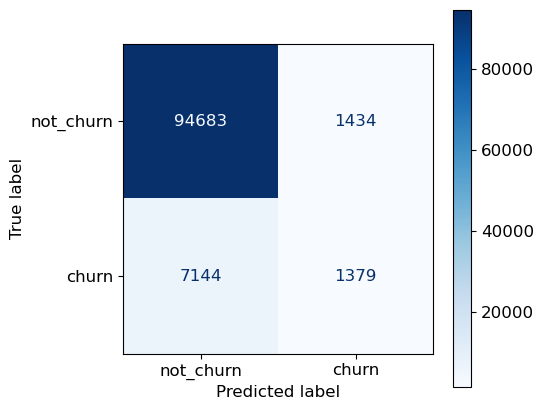

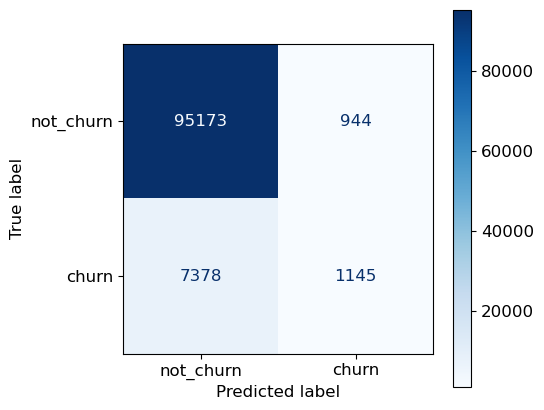

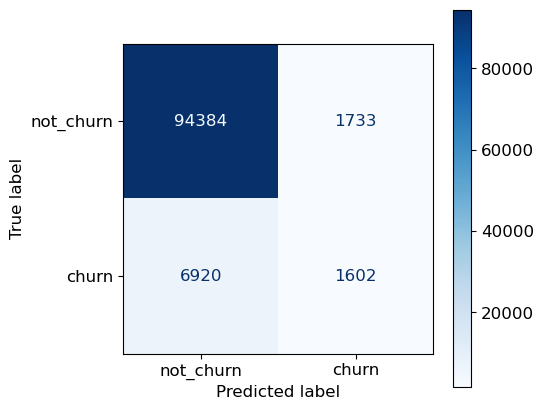

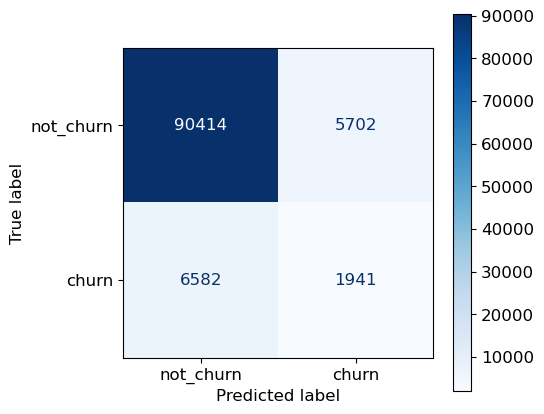

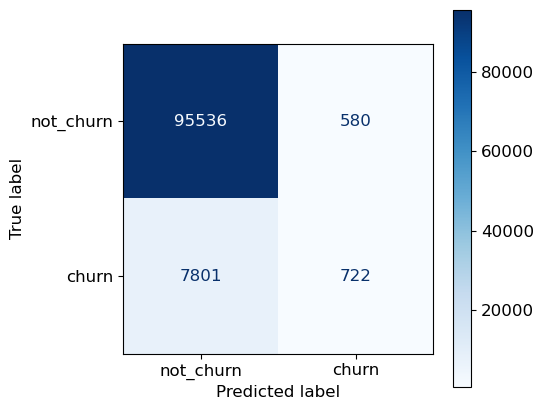

In [48]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)
    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    

#     ## applying pca
#     n_comp = 5

#     pca = PCA(n_components=n_comp)
#     pca.fit(X_train)
#     X_train = pd.DataFrame(pca.transform(X_train), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))
#     X_test = pd.DataFrame(pca.transform(X_test), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))

    clf_ridge = RandomForestClassifier(random_state=42) 
#     clf_ridge = LinearSVC(C=0.01, penalty="l1", dual=False)
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)
#     pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [ ]:
df_tto_re_pv[df_tto_re_pv['label'] == 1].head(50)

In [51]:
importances.head()

,importance
feature,
TRO_NET 2021-11,0.1
BASKET 11,0.0
SLA 2021-11,0.0
SINCE_REGIS,0.0
TRO_DH_SPESIAL 2021-11,0.0


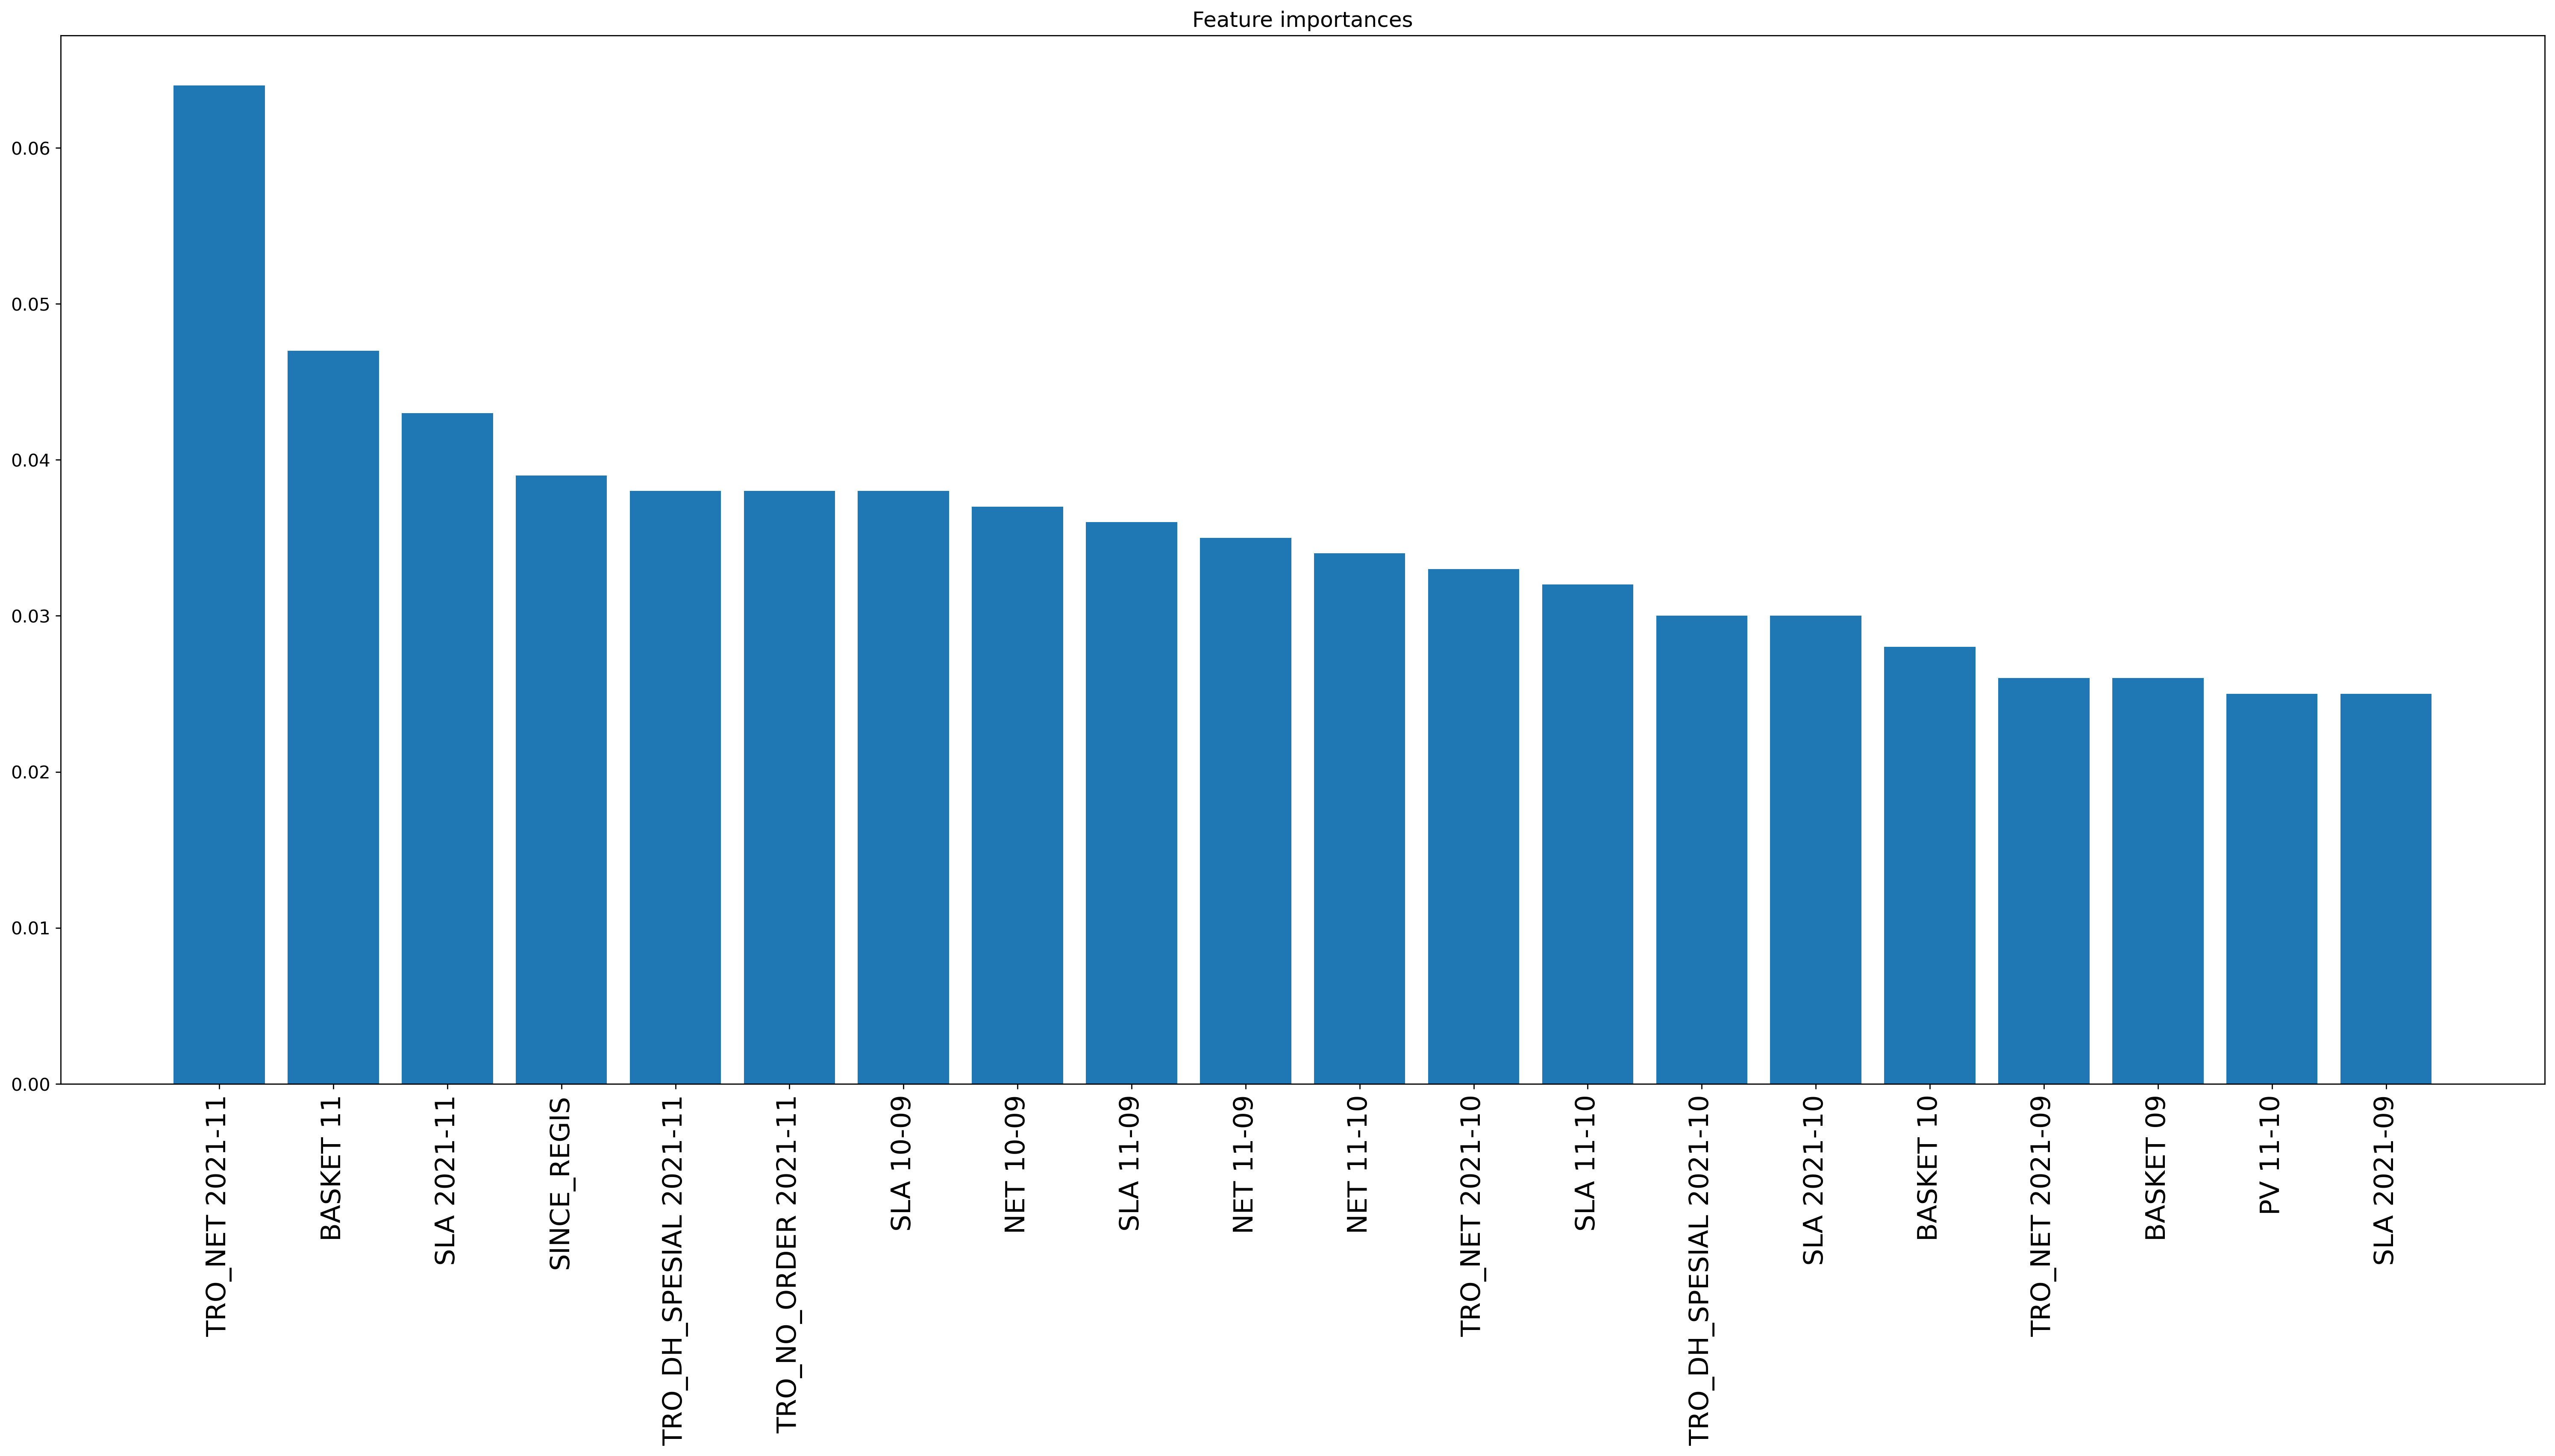

In [49]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(clf_ridge.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances = importances[0:20]
x_range = list(range(importances.shape[0]))
x_plot = list(importances.index)
y_plot = list(importances["importance"])
plt.figure(figsize=(30,13), dpi=250)
plt.title("Feature importances")
plt.bar(x_range, y_plot)
plt.xticks(x_range, x_plot, rotation='vertical', fontsize=18)
fig = plt.gcf()


### not oversampling version without threshold 3/3

In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [ ]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [ ]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

In [ ]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

### rf oversampling version 2/3

In [ ]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)

# condition_0_3 = ( 
#           (df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
#           (df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
#           (df_tto_re_pv['TRO_NET 2021-11'] == 0) & \
#           (df_tto_re_pv['TRO_NET 2021-12'] > 0) 
# )
# df_tto_re_pv = df_tto_re_pv[~condition_0_3]

df_tto_re_pv = df_tto_re_pv.fillna(0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]



    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


    from imblearn.over_sampling import SMOTE
    oversampler = SMOTE(random_state=0)
    X_train ,y_train = oversampler.fit_resample(X_train, y_train)


    clf_ridge = RandomForestClassifier(n_jobs=32) 
    clf_ridge.fit(X_train, y_train) 
    # pred = clf_ridge.predict(X_test)
    pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)


    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    display(ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd'))

### rf over oversampling 3/3

In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

from sklearn.model_selection import StratifiedKFold



X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]



    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


    from imblearn.over_sampling import SMOTE
    oversampler = SMOTE(random_state=0)
    X_train ,y_train = oversampler.fit_resample(X_train, y_train)


    clf_ridge = RandomForestClassifier(n_jobs=32) 
    clf_ridge.fit(X_train, y_train) 
    # pred = clf_ridge.predict(X_test)
    pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)


    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    display(ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd'))

In [ ]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [ ]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

In [ ]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

## XGBOOST

### not oversampling 2/3

In [ ]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]


skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    


    clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)

    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [ ]:
# condition_2_3 = (
# ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
# ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
# ((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0))
# )

# df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


# X = df_tto_re_pv.drop(
# [
# 'TRO_MEMBERS',
# 'TRO_NET 2021-12', 
# 'TRO_NO_ORDER 2021-12',
# 'SLA 2021-12',
# 'SLA_LATE 2021-12',
# 'RATING_BELOW 2021-12',
# 'RATING_AVG 2021-12',
# 'PV 2021-12',
# 'TRO_VOUCHER_USAGE 2021-12',
# 'TRO_PAYMENT_METHOD 2021-12',
# 'label'
# ], 1
# )
# y = df_tto_re_pv['label']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

# clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
# clf_ridge.fit(X_train, y_train) 
# # pred_proba = clf_ridge.predict_proba(X_test)
# pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ConfusionMatrixDisplay.from_predictions(y_test, pred, 
#                                         cmap='Blues', display_labels= ['not_churn', 'churn'], 
#                                         ax = ax, values_format = 'd')


### not oversampling version 3/3

In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

## MLP ( 2/3 )

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     96117
           1       0.53      0.15      0.24      8523

    accuracy                           0.92    104640
   macro avg       0.73      0.57      0.60    104640
weighted avg       0.90      0.92      0.90    104640

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     96117
           1       0.56      0.07      0.13      8523

    accuracy                           0.92    104640
   macro avg       0.74      0.53      0.54    104640
weighted avg       0.89      0.92      0.89    104640

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     96117
           1       0.49      0.24      0.32      8522

    accuracy                           0.92    104639
   macro avg       0.71      0.61      0.64    104639
weighted avg       0.90      0.92      0.90    104639

              preci

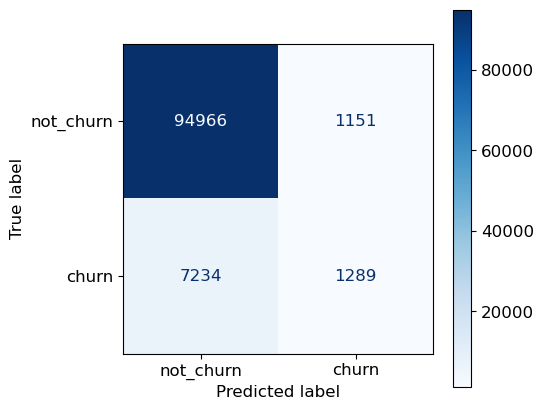

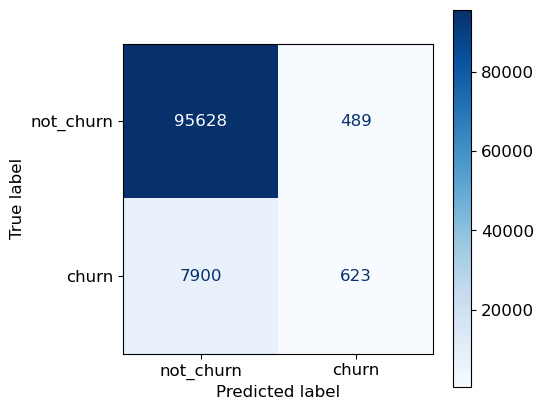

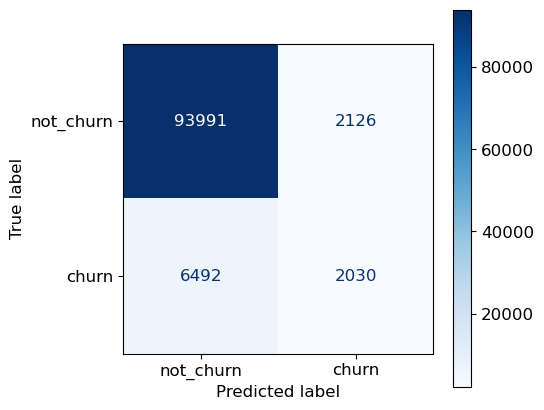

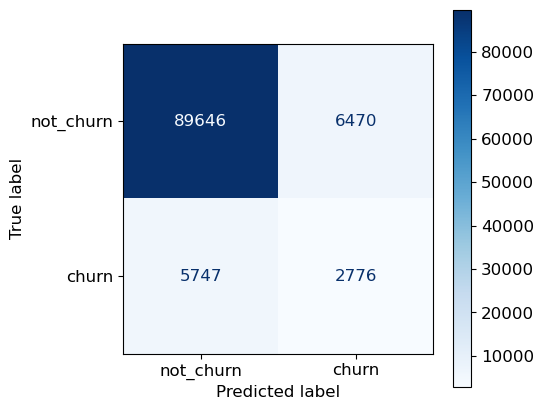

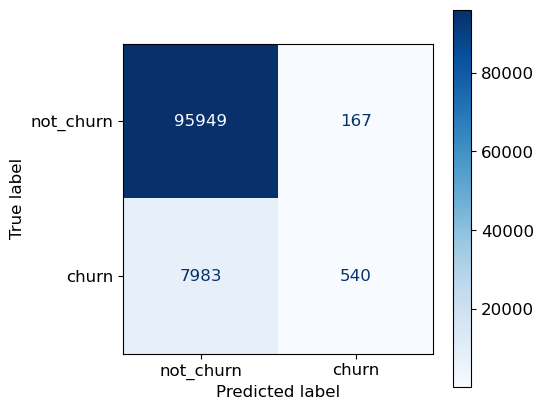

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)

df_tto_re_pv = df_tto_re_pv.fillna(0)
X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]





skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)
    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    

#     ## applying pca
#     n_comp = 5

#     pca = PCA(n_components=n_comp)
#     pca.fit(X_train)
#     X_train = pd.DataFrame(pca.transform(X_train), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))
#     X_test = pd.DataFrame(pca.transform(X_test), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))

    clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(15,))
#     clf_ridge = LinearSVC(C=0.01, penalty="l1", dual=False)
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)
#     pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [ ]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    


    clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(15,))
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)

    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

## MLP 2/3 oversampling

In [ ]:
from sklearn.neural_network import MLPClassifier


condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 



# pred = clf_ridge.predict(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [ ]:
condition = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 

pred = clf_ridge.predict(X_test)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax, values_format = 'd')

## simple ruling (construct own)

In [ ]:

condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)




X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

condition_2_3 = (
((X_test['NET_11-10'] < 0) & \
(X_test['NET_10-09'] < 0) & \
(X_test['NET_11-09'] < 0)
)
)

pred = np.where(condition_2_3, 1, 0)




print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [70]:
a = pd.DataFrame()

a['NET 11-10'] = df_tto_re_pv['TRO_NET 2021-12'] - df_tto_re_pv['TRO_NET 2021-11']
a['NET 10-09'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-10']
a['NET 11-09'] = df_tto_re_pv['TRO_NET 2021-12'] - df_tto_re_pv['TRO_NET 2021-10']

a['STRUK 11-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-12'] - df_tto_re_pv['TRO_NO_ORDER 2021-11']
a['STRUK 10-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']
a['STRUK 11-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-12'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']

a['PV 11-10'] = df_tto_re_pv['PV 2021-12'] - df_tto_re_pv['PV 2021-11']
a['PV 10-09'] = df_tto_re_pv['PV 2021-11'] - df_tto_re_pv['PV 2021-10']
a['PV 11-09'] = df_tto_re_pv['PV 2021-12'] - df_tto_re_pv['PV 2021-10']

a['SLA 11-10'] = df_tto_re_pv['SLA 2021-12'] - df_tto_re_pv['SLA 2021-11']
a['SLA 10-09'] = df_tto_re_pv['SLA 2021-11'] - df_tto_re_pv['SLA 2021-10']
a['SLA 11-09'] = df_tto_re_pv['SLA 2021-12'] - df_tto_re_pv['SLA 2021-10']

a['BASKET 11'] = df_tto_re_pv['TRO_NET 2021-12']/df_tto_re_pv['TRO_NO_ORDER 2021-12']
a['BASKET 10'] = df_tto_re_pv['TRO_NET 2021-11']/df_tto_re_pv['TRO_NO_ORDER 2021-11']
a['BASKET 09'] = df_tto_re_pv['TRO_NET 2021-10']/df_tto_re_pv['TRO_NO_ORDER 2021-10']

a['BASKET AVG'] = (df_tto_re_pv['BASKET 11'] + df_tto_re_pv['BASKET 10'] + df_tto_re_pv['BASKET 09']) / 3

In [71]:
X_12 = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-09', 
'TRO_DH_SPESIAL 2021-09',
'TRO_NO_ORDER 2021-09',
'SLA 2021-09',
'SLA_LATE 2021-09',
'RATING_BELOW 2021-09',
'RATING_AVG 2021-09',
'PV 2021-09',
'TRO_VOUCHER_USAGE 2021-09',
'TRO_PAYMENT_METHOD 2021-09',
'label'
], 1
)

X_12 = pd.concat([X_12.iloc[:,0:-16],a],1)
X_12 = X_12.fillna(0)
y_12 = df_tto_re_pv['label']

In [72]:
X_12.head()

,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_DH_SPESIAL 2021-10,TRO_DH_SPESIAL 2021-11,TRO_DH_SPESIAL 2021-12,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,TRO_VOUCHER_USAGE 2021-10,TRO_VOUCHER_USAGE 2021-11,TRO_VOUCHER_USAGE 2021-12,TRO_PAYMENT_METHOD 2021-10,TRO_PAYMENT_METHOD 2021-11,TRO_PAYMENT_METHOD 2021-12,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_BELOW 2021-12,RATING_AVG 2021-10,RATING_AVG 2021-11,RATING_AVG 2021-12,PV 2021-10,PV 2021-11,PV 2021-12,SINCE_REGIS,NET 11-10,NET 10-09,NET 11-09,STRUK 11-10,STRUK 10-09,STRUK 11-09,PV 11-10,PV 10-09,PV 11-09,SLA 11-10,SLA 10-09,SLA 11-09,BASKET 11,BASKET 10,BASKET 09,BASKET AVG
1,2412654.0000,3117811.0000,3217556.0000,109200.0000,131400.0000,138200.0000,35.0000,49.0000,40.0000,480.7667,630.0667,710.0667,1.0000,0.0000,1.0000,0.0000,200000.0000,85000.0000,1.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,27.0000,46.0000,38.0000,931.0000,99745.0000,705157.0000,804902.0000,-9.0000,14.0000,5.0000,-8.0000,19.0000,11.0000,80.0000,149.3000,229.3000,80438.9000,63628.7959,68932.9714,74047.0891
2,191267.0000,0.0000,0.0000,70400.0000,0.0000,0.0000,6.0000,0.0000,0.0000,9951.7000,0.0000,0.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.0000,0.0000,0.0000,743.0000,0.0000,-191267.0000,-191267.0000,0.0000,-6.0000,-6.0000,0.0000,-6.0000,-6.0000,0.0000,-9951.7000,-9951.7000,0.0000,0.0000,31877.8333,10625.9444
3,644400.0000,165315.0000,776032.0000,14300.0000,2200.0000,185500.0000,10.0000,3.0000,8.0000,214.8667,93.3500,158.9833,0.0000,1.0000,0.0000,0.0000,0.0000,70000.0000,1.0000,1.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,926.0000,610717.0000,-479085.0000,131632.0000,5.0000,-7.0000,-2.0000,0.0000,-4.0000,-4.0000,65.6333,-121.5167,-55.8833,97004.0000,55105.0000,64440.0000,56711.5000
4,0.0000,412904.0000,48908.0000,0.0000,124100.0000,27000.0000,0.0000,4.0000,1.0000,0.0000,34.5833,359.1667,0.0000,0.0000,1.0000,0.0000,10000.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,760.0000,-363996.0000,412904.0000,48908.0000,-3.0000,4.0000,1.0000,0.0000,1.0000,1.0000,324.5833,34.5833,359.1667,48908.0000,103226.0000,0.0000,34408.6667
5,39453.0000,65634.0000,130813.0000,6200.0000,400.0000,7200.0000,1.0000,2.0000,3.0000,436.9667,11.3500,103.2333,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,4.0000,909.0000,65179.0000,26181.0000,91360.0000,1.0000,1.0000,2.0000,0.0000,4.0000,4.0000,91.8833,-425.6167,-333.7333,43604.3333,32817.0000,39453.0000,32248.6667


In [83]:
X_12_scale = pd.DataFrame(scaler.transform(X_12), index=X_12.index, columns=X_12.columns)
pred = (clf_all.predict_proba(X_12_scale)[:,1] >= 0.6).astype(int)

In [84]:
pd.Series(pred).value_counts()

0    518175
1      5022
dtype: int64

In [86]:
df_tto_re_pv.shape

(523197, 59)

In [87]:
len(pred)

523197

In [88]:
df_tto_re_pv.head()

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_DH_SPESIAL 2021-09,TRO_DH_SPESIAL 2021-10,TRO_DH_SPESIAL 2021-11,TRO_DH_SPESIAL 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,TRO_VOUCHER_USAGE 2021-09,TRO_VOUCHER_USAGE 2021-10,TRO_VOUCHER_USAGE 2021-11,TRO_VOUCHER_USAGE 2021-12,TRO_PAYMENT_METHOD 2021-09,TRO_PAYMENT_METHOD 2021-10,TRO_PAYMENT_METHOD 2021-11,TRO_PAYMENT_METHOD 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_BELOW 2021-12,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,RATING_AVG 2021-12,PV 2021-09,PV 2021-10,PV 2021-11,PV 2021-12,SINCE_REGIS,NET 11-10,NET 10-09,NET 11-09,STRUK 11-10,STRUK 10-09,STRUK 11-09,PV 11-10,PV 10-09,PV 11-09,SLA 11-10,SLA 10-09,SLA 11-09,BASKET 11,BASKET 10,BASKET 09,BASKET AVG,label
1,9990010000001200,1791590.0000,2412654.0000,3117811.0000,3217556.0000,81500.0000,109200.0000,131400.0000,138200.0000,20.0000,35.0000,49.0000,40.0000,217.1000,480.7667,630.0667,710.0667,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,200000.0000,85000.0000,1.0000,1.0000,2.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,25.0000,27.0000,46.0000,38.0000,931.0000,705157.0000,621064.0000,1326221.0000,14.0000,15.0000,29.0000,19.0000,2.0000,21.0000,149.3000,263.6667,412.9667,63628.7959,68932.9714,89579.5000,74047.0891,0
2,9990010000004582,0.0000,191267.0000,0.0000,0.0000,0.0000,70400.0000,0.0000,0.0000,0.0000,6.0000,0.0000,0.0000,0.0000,9951.7000,0.0000,0.0000,0.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.0000,0.0000,0.0000,743.0000,-191267.0000,191267.0000,0.0000,-6.0000,6.0000,0.0000,-6.0000,6.0000,0.0000,-9951.7000,9951.7000,0.0000,0.0000,31877.8333,0.0000,0.0000,0
3,9990010000008534,202358.0000,644400.0000,165315.0000,776032.0000,5200.0000,14300.0000,2200.0000,185500.0000,4.0000,10.0000,3.0000,8.0000,73.3167,214.8667,93.3500,158.9833,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,70000.0000,1.0000,1.0000,1.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,926.0000,-479085.0000,442042.0000,-37043.0000,-7.0000,6.0000,-1.0000,-4.0000,4.0000,0.0000,-121.5167,141.5500,20.0333,55105.0000,64440.0000,50589.5000,56711.5000,0
4,9990010000031123,0.0000,0.0000,412904.0000,48908.0000,0.0000,0.0000,124100.0000,27000.0000,0.0000,0.0000,4.0000,1.0000,0.0000,0.0000,34.5833,359.1667,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,10000.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,760.0000,412904.0000,0.0000,412904.0000,4.0000,0.0000,4.0000,1.0000,0.0000,1.0000,34.5833,0.0000,34.5833,103226.0000,0.0000,0.0000,0.0000,0
5,9990010000034518,48952.0000,39453.0000,65634.0000,130813.0000,12900.0000,6200.0000,400.0000,7200.0000,2.0000,1.0000,2.0000,3.0000,1868.1667,436.9667,11.3500,103.2333,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.0000,0.0000,4.0000,4.0000,909.0000,26181.0000,-9499.0000,16682.0000,1.0000,-1.0000,0.0000,4.0000,-16.0000,-12.0000,-425.6167,-1431.2000,-1856.8167,32817.0000,39453.0000,24476.0000,32248.6667,0


In [100]:
df_mem_12 = pd.concat([df_tto_re_pv[['TRO_MEMBERS']].reset_index(drop=True), pd.DataFrame(pred, columns=['PRED'])], 1)

In [107]:
df_mem_12.to_csv('member_churn_jan.csv', index=False)